In [1]:
pip install unbabel-comet pandas tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# If needed, install:
# !pip -q install "unbabel-comet>=2.2.3" pandas tqdm pyarrow matplotlib

In [3]:
# If needed, install:
# !pip -q install "unbabel-comet>=2.2.3" pandas tqdm pyarrow matplotlib

import os, re, glob, gc
from pathlib import Path

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch

from comet import download_model, load_from_checkpoint

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

2025-09-14 14:34:01.773726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757860441.961222      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757860442.018546      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Torch: 2.6.0+cu124
CUDA available: True


In [4]:
# === change this to your folder ===
INPUT_DIR = "/kaggle/input/comet-evaluation"   # folder with translations_*.csv
OUTPUT_DIR = "comet_scored"
CLEAN_DIR  = "cleaned_csvs"       # optional: where to save cleaned copies

SUMMARY_BY_FILE = "comet_summary_by_file.csv"
MASTER_MIN_PARQUET = "comet_master_min.parquet"
GROUP_SUMMARY = "comet_group_summary.csv"

BATCH_SIZE = 32
DROP_ROWS_WITH_MISSING = True
DRY_RUN = False
DRY_RUN_N = 50

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
Path(CLEAN_DIR).mkdir(parents=True, exist_ok=True)

# Acceptable column aliases (case-insensitive)
COL_ALIASES = {
    "source": {"source", "src", "input", "source_text"},
    "reference": {"reference", "ref", "gold", "reference_text"},
    "translation": {"translation", "mt", "hypothesis", "hyp", "translation_text", "output"}
}


In [5]:
model_name = "Unbabel/wmt22-comet-da"  # reference-based, expects src/mt/ref
model_path = download_model(model_name)
model = load_from_checkpoint(model_path)
GPUS = 1 if torch.cuda.is_available() else 0
print(f"Loaded {model_name} | GPUS={GPUS}")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

LICENSE: 0.00B [00:00, ?B/s]

hparams.yaml:   0%|          | 0.00/567 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

checkpoints/model.ckpt:   0%|          | 0.00/2.32G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Loaded Unbabel/wmt22-comet-da | GPUS=1


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [6]:
# After loading the model, add:

def comet_predict_items(model, items, **kwargs):
    """Call model.predict and normalize outputs across COMET versions."""
    out = model.predict(items, **kwargs)

    # Case 1: old API -> tuple of (seg_scores, sys_score)
    if isinstance(out, tuple) and len(out) == 2:
        seg, sys = out

    # Case 2: newer API -> dict
    elif isinstance(out, dict):
        if "segments_scores" in out:       # common in 2.x
            seg = out["segments_scores"]
            sys = out.get("system_score", None)
        elif "scores" in out:              # some checkpoints use "scores"
            seg = out["scores"]
            sys = out.get("system_score", None)
        else:
            raise ValueError(f"Unexpected COMET predict() dict keys: {list(out.keys())}")

    # Case 3: object with attributes (very new variants / lightning wrappers)
    else:
        if hasattr(out, "segments_scores"):
            seg = out.segments_scores
            sys = getattr(out, "system_score", None)
        elif hasattr(out, "scores"):
            seg = out.scores
            sys = getattr(out, "system_score", None)
        else:
            raise ValueError(f"Unsupported predict() return type: {type(out)}")

    # If segments came as list of dicts, extract 'score'
    if seg and isinstance(seg[0], dict) and "score" in seg[0]:
        seg = [d["score"] for d in seg]

    # Final type normalization
    seg = [float(x) for x in seg]
    sys = float(np.mean(seg)) if sys is None else float(sys)
    return seg, sys

In [7]:
import re
from pathlib import Path

# Accept 2–5 letter codes on each side of the hyphen (e.g., cs-en, pt-br, zh-cn, etc.)
LANGPAIR_RE = re.compile(r"^[a-z]{2,5}-[a-z]{2,5}$", re.IGNORECASE)

# Canonical casing for your models
CANONICAL_MODELS = {
    "olmo-1b-0724-hf": "OLMo-1B-0724-hf",
    "phi-3.5-mini-instruct": "Phi-3.5-mini-instruct",
    "qwen2.5-0.5b-instruct": "Qwen2.5-0.5B-Instruct",
    "qwen2.5-1.5b-instruct": "Qwen2.5-1.5B-Instruct",
    "qwen2.5-3b-instruct": "Qwen2.5-3B-Instruct",
    "gemma-7b-it": "gemma-7b-it",
    "gemma2-9b-it": "gemma2-9b-it",
    "llama-3.1-70b-versatile": "llama-3.1-70b-versatile",
    "llama-3.1-8b-instant": "llama-3.1-8b-instant",
    "llama-3.2-90b-vision-preview": "llama-3.2-90b-vision-preview",
    "llama3-groq-70b-8192-tool-use-preview": "llama3-groq-70b-8192-tool-use-preview",
    "llama3-groq-8b-8192-tool-use-preview": "llama3-groq-8b-8192-tool-use-preview",
    "mixtral-8x7b-32768": "mixtral-8x7b-32768",
}

In [8]:
def parse_filename(path: Path):
    """
    Supports:
      translations_<MODEL>_<LANGPAIR>_<DIRECTION>.csv
      translations_<MODEL>_<LANGPAIR>.csv
    Where:
      <LANGPAIR> like cs-en, zh-cn, pt-br, etc.
      <DIRECTION> is 'original' or 'reverse' (optional)
    """
    stem = path.stem  # e.g., translations_llama-3.2-90b-vision-preview_kk-en
    # strip prefix
    for pref in ("translations_", "translation_"):
        if stem.lower().startswith(pref):
            rest = stem[len(pref):]
            break
    else:
        rest = stem

    # First try: split off 2 tokens from the right (model, lang, dir)
    parts = rest.rsplit("_", 2)
    model = lang_pair = direction = None

    if len(parts) == 3:
        maybe_model, maybe_lang, maybe_dir = parts[0], parts[1].lower(), parts[2].lower()
        if maybe_dir in {"original", "reverse"} and LANGPAIR_RE.match(maybe_lang):
            model, lang_pair, direction = maybe_model, maybe_lang, maybe_dir
        else:
            # Not (lang,dir). Try: last token is lang only (no direction); fold middle into model.
            maybe_model2 = f"{parts[0]}_{parts[1]}"
            maybe_lang2 = parts[2].lower()
            if LANGPAIR_RE.match(maybe_lang2):
                model, lang_pair, direction = maybe_model2, maybe_lang2, "unspecified"

    # Second try: split off 1 token from the right (model, lang)
    if model is None and len(parts) >= 2:
        parts2 = rest.rsplit("_", 1)
        maybe_model, maybe_lang = parts2[0], parts2[1].lower()
        if LANGPAIR_RE.match(maybe_lang):
            model, lang_pair, direction = maybe_model, maybe_lang, "unspecified"

    if model is None or lang_pair is None:
        return {"model": "UNKNOWN", "lang_pair": "UNKNOWN",
                "src_lang": "", "tgt_lang": "", "direction": "UNKNOWN"}

    # Canonicalize model casing if we know it
    model_key = model.lower()
    model = CANONICAL_MODELS.get(model_key, model)

    src_lang, tgt_lang = lang_pair.split("-")
    return {
        "model": model,
        "lang_pair": lang_pair,
        "src_lang": src_lang,
        "tgt_lang": tgt_lang,
        "direction": direction,
    }

In [9]:
import glob
import pandas as pd

def validate_filenames(input_dir: str):
    rows_ok, rows_bad = [], []
    for f in glob.glob(str(Path(input_dir) / "*.csv")):
        meta = parse_filename(Path(f))
        (rows_bad if (meta["model"]=="UNKNOWN" or meta["lang_pair"]=="UNKNOWN") else rows_ok).append(
            {"file": Path(f).name, **meta}
        )
    return pd.DataFrame(rows_ok), pd.DataFrame(rows_bad)

# Example:
df_ok, df_bad = validate_filenames(INPUT_DIR)
# display(df_ok.head())
display(df_bad)  # should be empty now; if not, paste a few filenames and I’ll extend the parser

""


In [10]:
# # Pattern like: translations_OLMo-1B-0724-hf_cs-en_original.csv
# STEM_RE = re.compile(
#     r"^translations_(?P<model>.+)_(?P<langpair>[a-z]{2,3}-[a-z]{2,3})_(?P<direction>original|reverse)$",
#     re.IGNORECASE
# )

# def parse_filename(path: Path):
#     m = STEM_RE.match(path.stem)
#     if not m:
#         return {"model":"UNKNOWN","lang_pair":"UNKNOWN","src_lang":"","tgt_lang":"","direction":"UNKNOWN"}
#     model = m.group("model")
#     lang_pair = m.group("langpair").lower()
#     direction = m.group("direction").lower()
#     src_lang, tgt_lang = lang_pair.split("-")
#     return {"model": model, "lang_pair": lang_pair, "src_lang": src_lang, "tgt_lang": tgt_lang, "direction": direction}

In [11]:
import unicodedata as ud

def map_columns(df: pd.DataFrame):
    low = {c.lower().strip(): c for c in df.columns}
    def pick(keys):
        for k in keys:
            if k in low: return low[k]
        raise KeyError(f"Missing expected column. Have: {list(df.columns)}")
    src = pick(COL_ALIASES["source"])
    ref = pick(COL_ALIASES["reference"])
    mt  = pick(COL_ALIASES["translation"])
    return src, ref, mt

def strip_outer_quotes(s: str) -> str:
    s = s.strip()
    if (s.startswith('"') and s.endswith('"')) or (s.startswith("'") and s.endswith("'")):
        return s[1:-1].strip()
    return s

def normalize_spaces(s: str) -> str:
    s = re.sub(r"[ \t]+", " ", s)
    s = re.sub(r"\r\n|\r|\n", "\n", s)    # unify newlines
    s = re.sub(r"\n{3,}", "\n\n", s)      # collapse >2 blank lines
    return s.strip()

def english_like_chunk(s: str) -> bool:
    if not s: return False
    ascii_ratio = sum(ch.isascii() for ch in s) / max(1, len(s))
    return ascii_ratio > 0.9

def extract_mt(raw: str) -> str:
    """Extract the actual translation from a stringy model output."""
    if not isinstance(raw, str):
        raw = "" if pd.isna(raw) else str(raw)
    s = strip_outer_quotes(raw)
    s = s.replace("\u200b", "")    # zero-width
    s = ud.normalize("NFKC", s)

    # If there are obvious markers, take the substring after the last one.
    markers = ["A:", "Output:", "English:", "Translation:"]
    last_pos, last_m = -1, None
    for m in markers:
        pos = s.rfind(m)
        if pos > last_pos:
            last_pos, last_m = pos, m
    if last_pos != -1:
        s = s[last_pos + len(last_m):].strip()

    # If no markers worked: choose the last 'paragraph' that looks English-like.
    if not s or "Translate the following text" in s:
        parts = re.split(r"\n\s*\n", s)
        for part in reversed([p.strip() for p in parts if p.strip()]):
            if english_like_chunk(part):
                s = part
                break

    return normalize_spaces(s)

def clean_text_basic(x):
    """Basic cleaner for Source/Reference in case quotes/newlines leak in."""
    if not isinstance(x, str):
        x = "" if pd.isna(x) else str(x)
    x = strip_outer_quotes(x)
    x = ud.normalize("NFKC", x)
    return normalize_spaces(x)

In [12]:
def map_columns(df: pd.DataFrame):
    low = {c.lower().strip(): c for c in df.columns}
    def pick(keys):
        for k in keys:
            if k in low: return low[k]
        raise KeyError(f"Missing expected column. Have: {list(df.columns)}")
    src = pick(COL_ALIASES["source"])
    ref = pick(COL_ALIASES["reference"])
    mt  = pick(COL_ALIASES["translation"])
    return src, ref, mt

def clean_text(x):
    if isinstance(x, str): return x.strip()
    return "" if pd.isna(x) else str(x).strip()

def to_items(df, src, ref, mt):
    return [{"src": clean_text(s), "ref": clean_text(r), "mt": clean_text(m)}
            for s, r, m in zip(df[src], df[ref], df[mt])]

In [13]:
# Dry-run cell:
csvs = sorted(glob.glob(str(Path(INPUT_DIR) / "*.csv")))
assert csvs, f"No CSVs found in {INPUT_DIR}"

test_df = pd.read_csv(csvs[0], encoding="utf-8-sig")
scol, rcol, mcol = map_columns(test_df)
mini = test_df.head(3)

seg, sys = comet_predict_items(model, to_items(mini, scol, rcol, mcol),
                               batch_size=8, gpus=GPUS, progress_bar=True)
print("OK. Example segment scores:", seg, " | mean:", sys)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


OK. Example segment scores: [0.44930437207221985, 0.4413253664970398, 0.5849421620368958]  | mean: 0.4918573002020518


In [14]:
all_min = []
by_file = []

for path_str in tqdm(csvs, desc="Cleaning + scoring"):
    p = Path(path_str)
    meta = parse_filename(p)

    # Always read as strings (preserve exact content)
    df = pd.read_csv(p, dtype=str, keep_default_na=False, na_values=[],
                     encoding="utf-8-sig", engine="python")

    scol, rcol, mcol = map_columns(df)
    df = df[[scol, rcol, mcol]].copy()

    if DROP_ROWS_WITH_MISSING:
        df = df[(df[scol].astype(str).str.strip()!="") &
                (df[rcol].astype(str).str.strip()!="") &
                (df[mcol].astype(str).str.strip()!="")].reset_index(drop=True)

    if DRY_RUN:
        df = df.head(DRY_RUN_N).copy()

    # Clean
    df["source"] = df[scol].apply(clean_text_basic)
    df["reference"] = df[rcol].apply(clean_text_basic)
    df["translation_clean"] = df[mcol].apply(extract_mt)

    # (Optional) write a cleaned copy for audit
    clean_out = Path(CLEAN_DIR) / f"{p.stem}_clean.csv"
    df[["source","translation_clean","reference"]].to_csv(clean_out, index=False, encoding="utf-8-sig")

    # Prepare COMET items
    items = [{"src": s, "mt": t, "ref": r}
             for s, t, r in zip(df["source"], df["translation_clean"], df["reference"])]

    # seg_scores, sys_score = model.predict(
    #     items, batch_size=BATCH_SIZE, gpus=GPUS, progress_bar=True
    # )

    seg_scores, sys_score = comet_predict_items(
        model, items, batch_size=BATCH_SIZE, gpus=GPUS, progress_bar=True
    )

    # Per-file scored output
    out = pd.DataFrame({
        "file": p.name,
        "model": meta["model"],
        "lang_pair": meta["lang_pair"],
        "src_lang": meta["src_lang"],
        "tgt_lang": meta["tgt_lang"],
        "direction": meta["direction"],
        "source": df["source"],
        "translation": df["translation_clean"],
        "reference": df["reference"],
        "COMET": seg_scores
    })
    out_path = Path(OUTPUT_DIR) / f"{p.stem}_scored.csv"
    out.to_csv(out_path, index=False, encoding="utf-8-sig")

    # Accumulate minimal rows for summaries
    all_min.append(out[["file","model","lang_pair","src_lang","tgt_lang","direction","COMET"]])

    arr = np.asarray(seg_scores, dtype=float)
    by_file.append({
        "file": p.name,
        "model": meta["model"],
        "lang_pair": meta["lang_pair"],
        "src_lang": meta["src_lang"],
        "tgt_lang": meta["tgt_lang"],
        "direction": meta["direction"],
        "n_segments": int(arr.size),
        "mean": float(arr.mean()),
        "median": float(np.median(arr)),
        "std": float(arr.std(ddof=1)) if arr.size > 1 else 0.0,
        "p10": float(np.percentile(arr,10)),
        "p25": float(np.percentile(arr,25)),
        "p75": float(np.percentile(arr,75)),
        "p90": float(np.percentile(arr,90)),
    })

# Write summaries
summary_df = pd.DataFrame(by_file)
summary_df.to_csv(SUMMARY_BY_FILE, index=False, encoding="utf-8-sig")

master_min = pd.concat(all_min, ignore_index=True) if all_min else pd.DataFrame()
if not master_min.empty:
    master_min.to_parquet(MASTER_MIN_PARQUET, index=False)
print("Done.")

Cleaning + scoring:   0%|          | 0/194 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Done.


,model,lang_pair,src_lang,tgt_lang,direction,n_segments,mean,median,std,p10,p25,p75,p90
145,llama-3.2-90b-vision-preview,en-bn,en,bn,unspecified,100,0.928823,0.936481,0.037188,0.884837,0.913764,0.954112,0.962765
119,llama-3.1-70b-versatile,en-bn,en,bn,unspecified,100,0.928065,0.938167,0.038524,0.890399,0.916503,0.952645,0.962207
158,llama3-groq-70b-8192-tool-use-preview,en-bn,en,bn,unspecified,100,0.915348,0.931697,0.081245,0.881041,0.904153,0.946227,0.960040
116,llama-3.1-70b-versatile,bn-en,bn,en,unspecified,100,0.912613,0.916255,0.031945,0.878310,0.889618,0.932382,0.947905
142,llama-3.2-90b-vision-preview,bn-en,bn,en,unspecified,100,0.912605,0.915472,0.033383,0.877605,0.889631,0.933017,0.952672
155,llama3-groq-70b-8192-tool-use-preview,bn-en,bn,en,unspecified,100,0.901793,0.906950,0.033502,0.858767,0.878352,0.924589,0.945377
123,llama-3.1-70b-versatile,gu-en,gu,en,unspecified,100,0.889624,0.899776,0.053780,0.801256,0.870721,0.923331,0.943989
127,llama-3.1-70b-versatile,tr-en,tr,en,unspecified,100,0.889111,0.896044,0.054144,0.825382,0.865954,0.923837,0.950171
153,llama-3.2-90b-vision-preview,tr-en,tr,en,unspecified,100,0.888997,0.898116,0.054123,0.830772,0.867064,0.923332,0.947078
149,llama-3.2-90b-vision-preview,gu-en,gu,en,unspecified,100,0.888708,0.902496,0.052496,0.815015,0.866783,0.922243,0.940633


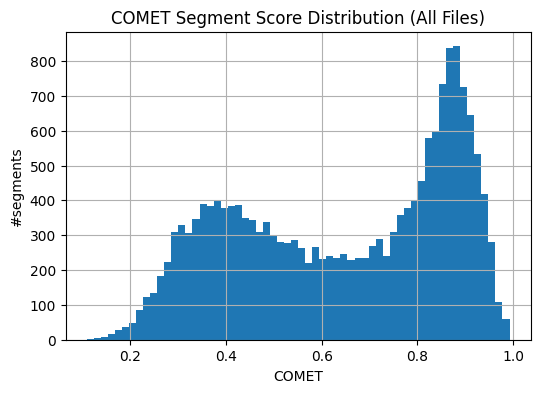

In [15]:
if not master_min.empty:
    grp = (master_min
           .groupby(["model","lang_pair","src_lang","tgt_lang","direction"])
           .agg(n_segments=("COMET","count"),
                mean=("COMET","mean"),
                median=("COMET","median"),
                std=("COMET", lambda x: float(np.std(x, ddof=1)) if len(x)>1 else 0.0),
                p10=("COMET", lambda x: float(np.percentile(x,10))),
                p25=("COMET", lambda x: float(np.percentile(x,25))),
                p75=("COMET", lambda x: float(np.percentile(x,75))),
                p90=("COMET", lambda x: float(np.percentile(x,90))))
           .reset_index())
    grp.to_csv(GROUP_SUMMARY, index=False, encoding="utf-8-sig")
    display(grp.sort_values("mean", ascending=False).head(10))

    # Simple distribution plot
    master_min["COMET"].hist(bins=60, figsize=(6,4))
    plt.title("COMET Segment Score Distribution (All Files)")
    plt.xlabel("COMET"); plt.ylabel("#segments"); plt.show()

In [16]:
# Build "one big table" CSV like your PDF: rows = LanguagePair|Direction, cols = models, values = mean COMET
import os, re, glob
from pathlib import Path
import pandas as pd
import numpy as np

BASE_DIRS = [Path("/mnt/data"), Path(".")]
SUMMARY_NAME = "comet_summary_by_file.csv"
OUT_CSV = Path("/kaggle/working/COMET_results_table.csv")

STEM_RE = re.compile(
    r"^translations_(?P<model>.+)_(?P<langpair>[a-z]{2,3}-[a-z]{2,3})_(?P<direction>original|reverse)$",
    re.IGNORECASE
)

def parse_filename(p: Path):
    m = STEM_RE.match(p.stem)
    if not m:
        return None
    d = m.groupdict()
    return {"file": p.name, "model": d["model"], "lang_pair": d["langpair"].lower(), "direction": d["direction"].lower()}

# Find summary if present
summary_path = next((b/ "comet_summary_by_file.csv" for b in BASE_DIRS if (b/ "comet_summary_by_file.csv").exists()), None)

# Gather file metadata for skeleton
recs = []
for b in BASE_DIRS:
    for ps in glob.glob(str(b / "translations_*.csv")):
        meta = parse_filename(Path(ps))
        if meta: recs.append(meta)
file_meta = pd.DataFrame(recs).drop_duplicates() if recs else pd.DataFrame(columns=["file","model","lang_pair","direction"])

# Build table
if summary_path:
    summ = pd.read_csv(summary_path)
    # Normalize column naming
    if "mean" not in summ.columns:
        for alt in ["system_mean","avg_comet","COMET_mean"]:
            if alt in summ.columns:
                summ = summ.rename(columns={alt:"mean"})
                break
    if "mean" not in summ.columns:
        summ["mean"] = np.nan
    summ["row_key"] = summ["lang_pair"].astype(str) + " | " + summ["direction"].astype(str)
    wide = (summ.pivot_table(index="row_key", columns="model", values="mean", aggfunc="mean")
                 .sort_index()
                 .reset_index()
                 .rename(columns={"row_key":"LanguagePair | Direction"}))
else:
    if file_meta.empty:
        wide = pd.DataFrame({"LanguagePair | Direction": []})
    else:
        file_meta["row_key"] = file_meta["lang_pair"].astype(str) + " | " + file_meta["direction"].astype(str)
        rows = sorted(file_meta["row_key"].unique())
        models = sorted(file_meta["model"].unique())
        wide = pd.DataFrame({"LanguagePair | Direction": rows})
        for m in models: wide[m] = np.nan

# Save
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)
wide.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print(f"Saved table to: {OUT_CSV}")

Saved table to: /kaggle/working/COMET_results_table.csv
